In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sunau
from scipy import signal
from scipy.io import wavfile
import pandas as pd
import pywt
import librosa
import python_speech_features
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import pywt # Python wavelet transform implementation
from sklearn.base import BaseEstimator, TransformerMixin # Interfaces and base classes for pipeline components
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft, ifft

In [2]:
class Normalizer(TransformerMixin, BaseEstimator):
    """
    Normalizes sample data to the interval (-1, 1)
    
    Parameters
    ----------
    
    """
    def __init__(self, nbits: int, signed: bool):
        self.signed = signed
        self.nbits = nbits
        if self.signed:
            self.nbits = self.nbits-1
    
    def transform(self, samples: np.array) -> np.array:
        normalized_samples = samples/(2**self.nbits) 
        normalized_samples = np.clip(normalized_samples, -1, 1)
        return normalized_samples
    
    def fit(self, X, y):
        return self

In [3]:
class NormFFT(TransformerMixin, BaseEstimator):
    
    def __init__(self, n: int = 5000):
        self.n=n
        
    def transform(self, normalized_samples: np.array) -> (np.array, np.array, np.array):
        transformed_samples = fft(normalized_samples, n=self.n) # calculate fourier transform (complex numbers list)
        #length = len(transformed_samples)/2  # you only need half of the fft list (real signal symmetry)
        #halved_transform = transformed_samples[:, 0:int(length-1)]
        #return np.abs(halved_transform), np.real(halved_transform), np.imag(halved_transform)
        return np.abs(transformed_samples)
    
    def fit(self, X, y):
        return self

In [4]:
class WaveletTransformer(TransformerMixin, BaseEstimator):
    """Compute approximation coefficients of a selected wavelet.
    
    Parameters
    ----------
    wavelet_name : str, default='db1'
        Wavelet to use in transformation.
        Must be a wavelet name defiend in PyWavelets library
        See http://wavelets.pybytes.com/
    mode : str, default='symmetric'
        Extrapolation mode for transform.
        See https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes
    Attributes
    ----------
    n_features_ : int
        The number of features of the data passed to :meth:`fit`.
    wavelet_name : str, default='db1'
        Wavelet to use in transformation.
        See http://wavelets.pybytes.com/
    mode : str, default='symmetric'
        Extrapolation mode for transform.
        See https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes
    
    """
    def __init__(self,
                 wavelet_name: str = 'db1',
                 mode: str = 'symmetric'):
        self.wavelet_name = wavelet_name
        self.mode = mode

    def fit(self, X, y=None):
        """A reference implementation of a fitting function for a transformer.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : None
            There is no need of a target in a transformer, yet the pipeline API
            requires this parameter.
        Returns
        -------
        self : object
            Returns self.
        """
        X = check_array(X, accept_sparse=True)

        # Each row of X must have the same length
        # In other words, signals need to be truncated or padded to a fixed length
        # prior to passing to this transformer.
        self.n_features_ = X.shape[1]

        # Other checks go here
        
        # Return the transformer
        return self

    def transform(self, X):
        """ Compute wavelet transform on input data X
        
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, n_features)
            The array containing the wavelet transform approximation coefficients from each row of X
            in ``X``.
        """
        # Check is fit had been called
        check_is_fitted(self, 'n_features_')

        # Input validation
        X = check_array(X, accept_sparse=True)

        # Check that the input is of the same shape as the one passed
        # during fit.
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')
            
        (cA, cD) = pywt.dwt(X, self.wavelet_name, self.mode)
        return cA

In [5]:
def loadAudio(audioPath):
    sample_rate, samples = wavfile.read(audioPath)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    spectrogram = np.log(spectrogram)
    transposed_spec = spectrogram.transpose()
    freq_list = list(frequencies)
    #freq_list = [str(f) for f in freq_list]
    #freq_list = [f + " Hz" for f in freq_list]
    audio_df = pd.DataFrame(transposed_spec, index = times, columns = freq_list )
    audio_df.index = times
    audio_df
    return [audio_df, samples, sample_rate]

In [6]:
from random import randrange
import numpy as np
def make_random_signal(freq1, freq2, length=1000, noise_level=25):
    """
    Make a wave and add random noise
    The signal is composed of x/100 and x/20. The amplitude and horizontal shift is randomly chosen
    """
    shift = randrange(101) # Random int between 0 and 100
    amplitude_f1 = randrange(0,1001) # Amplitude of frequency 1
    amplitude_f2 = randrange(0,1001) # Amplitude of frequency 2
    raw_signal = np.array([amplitude_f1*np.sin((x+shift)*freq1) + amplitude_f2*np.cos((x+shift)*freq2) for x in range(0,length)])
    noisy_signal = raw_signal + np.random.normal(0, noise_level, length)
    noisy_signal = noisy_signal.astype(np.int16)
    return noisy_signal

In [7]:
freq1a= randrange(1, 1000)/10
freq1b= randrange(1, 1000)/10
freq2a= randrange(1, 1000)/10
freq2b= randrange(1, 1000)/10

signal1 = make_random_signal(freq1a, freq1b, 44100)
signal2 = make_random_signal(freq2a, freq2b, 44100)
print("signal1: " + str(freq1a) + ", " + str(freq1b))
print("signal2: " + str(100) + ", " + str(100))

signal1: 29.2, 71.0
signal2: 100, 100


In [8]:
rand_freq1=randrange(1, 1000)/10
rand_freq2=randrange(1, 1000)/10
class1 = [make_random_signal(20, rand_freq1, 44100)  for i in range(1, 1001)]

In [9]:
class2 = [make_random_signal(50, rand_freq2, 44100)  for i in range(1, 1001)]

In [10]:
class2[0].shape

(44100,)

In [11]:
y_train = ([0]*1000) + ([1]*1000)
y_train = np.array(y_train)
y_train.shape

(2000,)

In [12]:
X_train = class1 + class2
X_train = np.array(X_train)
X_train.shape

(2000, 44100)

In [13]:
from scipy.io.wavfile import write
write("signal1.wav", 44100, signal1)
write("signal2.wav", 44100, signal2)

In [14]:
from sklearn.svm import SVC
pipe = Pipeline([('normalizer', Normalizer(16, True)), 
                 ('normfft', NormFFT(44100)),
                 ('minmaxscaler', MinMaxScaler()),
                 ('svc', SVC())
                ])

In [15]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('normalizer', Normalizer(nbits=15, signed=True)),
                ('normfft', NormFFT(n=44100)), ('minmaxscaler', MinMaxScaler()),
                ('svc', SVC())])

In [16]:
test_class1 = [make_random_signal(20, rand_freq1, 44100)  for i in range(1, 101)]
test_class2 = [make_random_signal(50, rand_freq2, 44100)  for i in range(1, 101)]
X_test = test_class1 + test_class2
X_test = np.array(X_test)
y_test = ([0]*100) + ([1]*100)
y_test = np.array(y_test)

In [17]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [18]:
X_test.shape

(200, 44100)

In [19]:
pipe.get_params()

{'memory': None,
 'steps': [('normalizer', Normalizer(nbits=15, signed=True)),
  ('normfft', NormFFT(n=44100)),
  ('minmaxscaler', MinMaxScaler()),
  ('svc', SVC())],
 'verbose': False,
 'normalizer': Normalizer(nbits=15, signed=True),
 'normfft': NormFFT(n=44100),
 'minmaxscaler': MinMaxScaler(),
 'svc': SVC(),
 'normalizer__nbits': 15,
 'normalizer__signed': True,
 'normfft__n': 44100,
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [20]:
#this cell and next are troubleshooting syntax and refreshers
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7, 8])
c = np.array([9, 10, 11, 12])
d = np.array([13, 14, 15, 16])
e = np.array([0]*4)
f = np.array([1]*4)
g = [a, b, c, d, e, f]
test = [g[i][0] for i in range(0, len(g))]
test

[1, 5, 9, 13, 0, 1]

In [21]:
#i think this syntax was messing us up
#using g[x][y] returns the y-th element from the x-th array of g (normal/expected behavior)
#using g["some-slice"][y] operates on the slice?
length = len(g)/2  # you only need half of the fft list (real signal symmetry)
g[2][1]

10

In [22]:
desk_path_list = ['C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap1.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap2.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap3.wav',
                     'C:\\Users\\kbk17\\EspionageDomainExploration\\desk_tap4.wav']
key_path_list = ['C:\\Users\\kbk17\\EspionageDomainExploration\\key_press1.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press2.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press3.wav',
                 'C:\\Users\\kbk17\\EspionageDomainExploration\\key_press4.wav']

In [23]:
desk_read_output = [loadAudio(x) for x in desk_path_list]
key_read_output = [loadAudio(x) for x in key_path_list]

In [24]:
desk_samples = [desk_read_output[i][1] for i in range(0,len(desk_read_output))]
desk_samples

[array([  -17,  -102,   -80, ..., -2649, -2548, -2529], dtype=int16),
 array([  359,   348,   358, ..., -1108, -1044, -1052], dtype=int16),
 array([  698,   713,   750, ..., -2063, -2160, -2139], dtype=int16),
 array([  113,   179,    99, ..., -1689, -1665, -1721], dtype=int16)]

In [25]:
key_samples = [key_read_output[i][1] for i in range(0,len(key_read_output))]
key_samples

[array([-1684, -1785, -1415, ...,  1145,  1071,   310], dtype=int16),
 array([-5741, -5481, -5774, ..., -3737, -3746, -3949], dtype=int16),
 array([   163,    510,    226, ..., -10299, -10038,  -9722], dtype=int16),
 array([ -772,  -757, -1090, ...,    65,   338,   150], dtype=int16)]

In [26]:
samples = key_samples + desk_samples
max_length = 0
for s in samples:
    if len(s) > max_length:
        max_length = len(s)
max_length

13435

In [27]:
#testing; remember np.pad() doesn't mutate input array but rather returns a new array
padded_b = []
b = [[0,1], [2,3,4,5], [6,7,8,9,10]]
for s in b:
    np.pad(s, (0, 5-len(s)), 'constant', constant_values=-2**15)
    padded_b.append(s)
padded_b

[[0, 1], [2, 3, 4, 5], [6, 7, 8, 9, 10]]

In [28]:
padded_samples = []
for s in samples:
    padded_s = np.pad(s, (0, max_length-len(s)), 'constant', constant_values=-2**15)
    padded_samples.append(padded_s)
padded_samples

[array([-1684, -1785, -1415, ...,  1145,  1071,   310], dtype=int16),
 array([ -5741,  -5481,  -5774, ..., -32768, -32768, -32768], dtype=int16),
 array([   163,    510,    226, ..., -32768, -32768, -32768], dtype=int16),
 array([  -772,   -757,  -1090, ..., -32768, -32768, -32768], dtype=int16),
 array([   -17,   -102,    -80, ..., -32768, -32768, -32768], dtype=int16),
 array([   359,    348,    358, ..., -32768, -32768, -32768], dtype=int16),
 array([   698,    713,    750, ..., -32768, -32768, -32768], dtype=int16),
 array([   113,    179,     99, ..., -32768, -32768, -32768], dtype=int16)]

In [29]:
len(samples[1])

13022

In [30]:
len(padded_samples)

8

In [31]:
padded_samples

[array([-1684, -1785, -1415, ...,  1145,  1071,   310], dtype=int16),
 array([ -5741,  -5481,  -5774, ..., -32768, -32768, -32768], dtype=int16),
 array([   163,    510,    226, ..., -32768, -32768, -32768], dtype=int16),
 array([  -772,   -757,  -1090, ..., -32768, -32768, -32768], dtype=int16),
 array([   -17,   -102,    -80, ..., -32768, -32768, -32768], dtype=int16),
 array([   359,    348,    358, ..., -32768, -32768, -32768], dtype=int16),
 array([   698,    713,    750, ..., -32768, -32768, -32768], dtype=int16),
 array([   113,    179,     99, ..., -32768, -32768, -32768], dtype=int16)]

In [32]:
samples

[array([-1684, -1785, -1415, ...,  1145,  1071,   310], dtype=int16),
 array([-5741, -5481, -5774, ..., -3737, -3746, -3949], dtype=int16),
 array([   163,    510,    226, ..., -10299, -10038,  -9722], dtype=int16),
 array([ -772,  -757, -1090, ...,    65,   338,   150], dtype=int16),
 array([  -17,  -102,   -80, ..., -2649, -2548, -2529], dtype=int16),
 array([  359,   348,   358, ..., -1108, -1044, -1052], dtype=int16),
 array([  698,   713,   750, ..., -2063, -2160, -2139], dtype=int16),
 array([  113,   179,    99, ..., -1689, -1665, -1721], dtype=int16)]

In [51]:
#added dtype=object to avoid jagged nparray error; this is accounted for in NormFFT.transform() (in fft( ..., n=self.n) to be exact)

X_train = np.array(samples, dtype=object) 

In [52]:
#let 0 represent key press, 1 desk tap
y_train = [0, 0, 0, 0, 1, 1, 1, 1]

In [56]:
pipe.fit(X_train, y_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Testing model with increased noise

In [39]:
noise_level = 40
class1 = [make_random_signal(20, rand_freq1, 44100, noise_level)  for i in range(1, 101)]
class2 = [make_random_signal(50, rand_freq2, 44100, noise_level)  for i in range(1, 101)]

(0.0, 100.0)

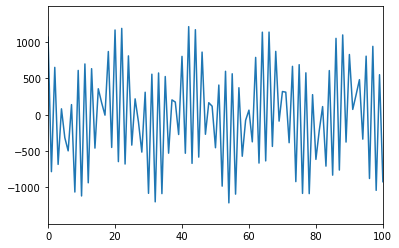

In [40]:
y = class2[1]
x = list(range(0,44100))
plt.plot(x, y)
plt.xlim(0, 100)

(0.0, 100.0)

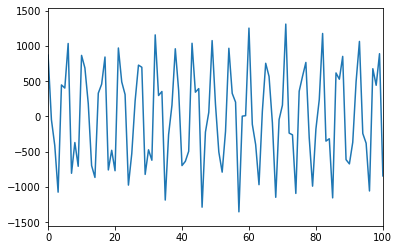

In [41]:
y = class1[1]
x = list(range(0,44100))
plt.plot(x, y)
plt.xlim(0, 100)

In [ ]:
def assess_classification_model(noise_level):
    class1 = [make_random_signal(20, rand_freq1, 44100, noise_level)  for i in range(1, 101)]
    class2 = [make_random_signal(50, rand_freq2, 44100, noise_level)  for i in range(1, 101)]
    X_test = np.array(class1 + class2)
    y_pred = pipe.predict(X_test)
    a = [0]*100
    b = [1]*100
    target = a + b
    print("Prediction at noise level: " + str(noise_level))
    print(y_pred)
    cm = confusion_matrix(target, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()
    precision, recall, f1, support = precision_recall_fscore_support(target, y_pred)
    precision = precision[1]
    recall = recall[1]
    f1 = f1[1]
    support = support[1]
    print((precision, recall, f1, support))

In [42]:
assess_classification_model(30)

NameError: name 'assess_classification_model' is not defined

In [ ]:
assess_classification_model(35)

In [ ]:
print(rand_freq1)
print(rand_freq2)

In [ ]:
assess_classification_model(37.5)

In [ ]:
assess_classification_model(40)

In [ ]:
class1 = [make_random_signal(20, rand_freq1, 44100, 35)  for i in range(1, 101)]
class2 = [make_random_signal(50, rand_freq2, 44100, 35)  for i in range(1, 101)]

In [ ]:
X_test = np.array(class1 + class2)
y_pred = pipe.predict(X_test)

In [ ]:
y_pred

In [ ]:
cm = confusion_matrix(target, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(target, y_pred)
precision = precision[1]
recall = recall[1]
f1 = f1[1]
support = support[1]
(precision, recall, f1, support)

In [ ]:
class1 = [make_random_signal(20, rand_freq1, 44100, 40)  for i in range(1, 101)]
class2 = [make_random_signal(50, rand_freq2, 44100, 40)  for i in range(1, 101)]

In [ ]:
a = [0]*100
b = [1]*100
target = a + b

In [ ]:
X_test = np.array(class1 + class2)
y_pred = pipe.predict(X_test)

In [ ]:
y_pred

In [ ]:
#assessing model at 1.5 the noise
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

cm = confusion_matrix(target, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [ ]:
#it is good practice to perform a confusion matrix (above) and Precision/Recall for all classification models
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(target, y_pred)
precision = precision[1]
recall = recall[1]
f1 = f1[1]
support = support[1]
(precision, recall, f1, support)

# Noise level experiment
- Generate training data with higher noise level
- Generate test data with same or different noise level
- Train model with generated data
- Evaluate model performance using sklearn metrics